# Credit Card Fraud Detection

## About

Credit card fraud detection is a real world problem that is plaguing the nations. It is an anomaly detection problem due to the Poisson distributed positive cases. Fraud doesn't happen every day, but when it does happen, we want to capture it and predict, given the types of patterns that we can detect, which accounts will likely experience an instance of fraudulent activity.

Being able to work with fraud detection gives us insight into working with all sorts of anomaly detection type problems in the feature, even outside this particular domain.

## The Dataset

The dataset was retrieved from data world, which retrieved it from a Kaggle competitition. It's a flat datset and not necessarily considered big data, however, it will serve its purpose here. 

The attributes for the dataset, for the most part, were stripped so we don't really have a human readable understanding of what the attributes mean, but from what I can tell, the values for each of these anonymized attributes are normalized values.

Our target is a boolean, indicating whether or not the account has experienced fraudulent activity or not.


## Download External Dependencies

In [1]:
!pip install pyod
!pip install imbalance-learn

     |████████████████████████████████| 92kB 4.0MB/s 
  Created wheel for pyod: filename=pyod-0.7.5-cp36-none-any.whl size=96597 sha256=ab14b4a9d755c5ef417857b58523d12b3580b3fa466ac7651785ffbb3c309a3c
  Stored in directory: /root/.cache/pip/wheels/35/bc/f4/2cef321eac851ba02f533e3921b296bb4ce4998c8a4c9a8d6e
Successfully built pyod
ERROR: Could not find a version that satisfies the requirement imbalance-learn (from versions: none)
ERROR: No matching distribution found for imbalance-learn


## Load Dependencies

In [0]:
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter
from inspect import signature
%matplotlib inline
import pandas as pd
import numpy as np
import pprint
pp = pprint.PrettyPrinter(indent=4)

from google.colab import drive
import pandas_profiling
from timeit import default_timer
from sklearn.metrics import (precision_score, confusion_matrix, recall_score, accuracy_score, 
                             balanced_accuracy_score,roc_auc_score, classification_report, confusion_matrix, 
                             r2_score, f1_score, roc_curve, precision_recall_curve, average_precision_score)
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import SGDClassifier

## Constants

In [0]:
DRIVENAME = "/content/drive/"
FILENAME = "/content/drive/My Drive/problem_set_challenges_for_job_postings/scaled_and_processed_cc.csv"

## Functions

In [0]:
def mount_drive(drivename):
    from google.colab import drive
    drive.mount(drivename)


def load_csv_file(path):
    dataframe = pd.read_csv(FILENAME)
    if isinstance(dataframe["Unnamed: 0"], pd.Series):
        dataframe = dataframe.drop('Unnamed: 0', inplace=False, axis=1)
    return dataframe


def drop_features(dataframe, cols):
    for col in cols:
        dataframe.drop(col, axis=1, inplace=True)
    return dataframe


def rename_target(dataframe, label):
    return dataframe.rename({label: "target"}, axis=1, inplace=False)


def remap_boolean(dataframe, label):
    return dataframe[label].replace({False:0, True:1}, inplace=False)


def scale_feature(dataframe, label):
    return dataframe[label].apply(lambda x: (x-dataframe[label].mean())/dataframe[label].std())


def preprocess(dataframe, cols_to_drop, cols_to_remap, cols_scale):
    start_time = default_timer()
    dataframe = drop_features(dataframe, cols_to_drop)
    dataframe = rename_target(dataframe, "class")
    dataframe[cols_to_remap] = remap_boolean(dataframe, cols_to_remap)
    dataframe[cols_scale] = scale_feature(dataframe, cols_scale)
    end_time = default_timer()
    print(f"Processing completed. Elapsed time: {end_time-start_time}")
    return dataframe


def split_data_into_feature_and_target(data, target_label="target"):
    """ Splits the dataframe into features and target
    :param data: is dataframe with last column on right as target
    """
    X = data.loc[:, data.columns != target_label].values
    y = data[target_label].values
    return X, y


def plot_pca(X, y, list_n_pca_components):
    """ plots a PCA plot... borrowed code that I want to touch as little as possible """
    from sklearn.decomposition import PCA
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import GridSearchCV
    from sklearn.linear_model import SGDClassifier
    from timeit import default_timer

    logistic = SGDClassifier(loss='log', penalty='l2', early_stopping=True,
                            max_iter=100, tol=1e-5, random_state=0)
    pca = PCA()
    pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

    # Parameters of pipelines can be set using ‘__’ separated parameter names:
    param_grid = {
        'pca__n_components': list_n_pca_components,
        'logistic__alpha': np.logspace(-4, 4, 5),
    }

    start_time = default_timer()
    search = GridSearchCV(pipe, param_grid, iid=False, cv=10)
    search.fit(X, y)
    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)

    # Plot the PCA spectrum
    pca.fit(X)
    end_time = default_timer()
    print("Elapsed time to fit: {}s".format(end_time - start_time))
    fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
    ax0.plot(pca.explained_variance_ratio_, linewidth=2)
    ax0.set_ylabel('PCA explained variance')

    ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
                linestyle=':', label='n_components chosen')
    ax0.legend(prop=dict(size=12))

    # For each number of components, find the best classifier results
    results = pd.DataFrame(search.cv_results_)
    components_col = 'param_pca__n_components'
    best_clfs = results.groupby(components_col).apply(
        lambda g: g.nlargest(1, 'mean_test_score'))

    best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
                legend=False, ax=ax1)
    ax1.set_ylabel('Classification accuracy (val)')
    ax1.set_xlabel('n_components')

    plt.tight_layout()
    plt.show()


def extract_pc_into_df(data, n_pca_components):
    from sklearn.linear_model import SGDClassifier
    from sklearn.decomposition import PCA

    X, y = split_data_into_feature_and_target(data)

    logistic = SGDClassifier(loss='log', penalty='l2', early_stopping=True,
                         max_iter=10000, tol=1e-5, random_state=0, alpha=0.0001)
    
    pca = PCA(n_components=n_pca_components)
    principal_components = pca.fit_transform(X, y)

    princ_comp_names = [f"pc{a}" for a in range(1, 12)]
    dataframe = pd.DataFrame(principal_components, columns=princ_comp_names)
    dataframe['target'] = data['target'].values

    return dataframe


def normality_of_distribution_test(feature, significance_level=0.05):
    from scipy.stats import normaltest
    test_normality = normaltest(feature, axis=0, nan_policy='propagate')
    if test_normality[1]<significance_level:
        print("This feature is normally distributed about the mean")
    else:
        print("This feature is NOT normally distributed about the mean")


def fit_simple_model(data, model_type):
    from timeit import default_timer
    X, y = split_data_into_feature_and_target(data)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    if model_type == "naive bayes":
        from sklearn.naive_bayes import GaussianNB
        model = GaussianNB()
    else:
        raise ValueError("Please select a valid model_type value")
    
    start_time = default_timer()
    fitted_model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end_time = default_timer()
    elapsed_time = end_time - start_time
    print(f"Model fitting and prediction complete.\nElapsed Time: {elapsed_time}s")
    return (X_train, X_test, y_train, y_test, y_pred), fitted_model, elapsed_time


def fit_get_predictions_with_CV(data, model_name, param_search_space):
    """ Uses the GridSearchCV to fit specified model. 
    param_search_space must be compatible with models passed in """
    from timeit import default_timer

    X, y = split_data_into_feature_and_target(data)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    if model_name == "RFC":
        from sklearn.ensemble import RandomForestClassifier
        estimator = RandomForestClassifier()
    
    elif model_name == "logistic regression":
        from sklearn.linear_model import LogisticRegression
        estimator = LogisticRegression(class_weight="balanced", verbose=0, random_state=42, 
                                       max_iter=100, solver="saga", warm_start=False, n_jobs=-1, 
                                       l1_ratio=1)
        
    elif model_name == "naive bayes":
        from sklearn.naive_bayes import GaussianNB
        estimator = GaussianNB()

    elif model_name == "KNN":
        from sklearn.neighbors import KNeighborsClassifier
        estimator = KNeighborsClassifier()
    
    else:
        raise ValueError("Please enter a valid model_name string value")

    start_time = default_timer()
    gscv = GridSearchCV(estimator, param_search_space, cv=10, error_score="raise")
    fitted_model = gscv.fit(X_train, y_train)
    y_pred = gscv.predict(X_test)
    end_time = default_timer()
    elapsed_time = end_time - start_time
    print(f"Training, Validation and Testing are complete.\nElapsed Time: {elapsed_time}s")
    return (X_train, X_test, y_train, y_test, y_pred), fitted_model, elapsed_time



def fit_predict_score_outlier_detection_models(model_type, X_train, X_test, y_train, y_test):
    """ fits a specified model within the allowable options """

    if model_type == "iforest":
        from pyod.models.iforest import IForest
        model = IForest(contamination=0.1, n_estimators=100, max_samples='auto', 
                        max_features=1.0, bootstrap=False, n_jobs=1, behaviour='old', 
                        random_state=42, verbose=0)

    elif model_type == "knn":
        from pyod.models.knn import KNN
        model = KNN(contamination=0.1, n_neighbors=5, method='largest', radius=1.0, 
                    algorithm='auto', leaf_size=30, metric='minkowski', 
                    p=2, metric_params=None, n_jobs=1)
        
    else:
        raise ValueError("Please pass in an accepted model.")
    
    model.fit(X=X_train, y=y_train)
    test_anomaly_scores = model.decision_function(X_test)
    training_anomaly_scores = model.decision_scores_
    y_pred = model.fit_predict(X_test)
    y_pred_probs = model.predict_proba(X_test)

    return (y_pred, y_pred_probs), (training_anomaly_scores, test_anomaly_scores), model



def conf_mat_parser(confusion_matrix):
    """ parse a confusion matrix into its components """""""""""
    TN, FN, FP, TP = [i for j in confusion_matrix for i in j]
    return TN, FN, FP, TP


def detailed_confusion_matrix(y_test, y_pred):
    """ prints out confusion matrix with more labeling and detail """

    TN, FP, FN, TP = conf_mat_parser(confusion_matrix(y_test, y_pred))
    sensitivity = (TP/(TP+FN))
    specificity = (TN/(TN+FP))
    precision = (TP / (TP+FP))

    print("                           *Fraudulent Cases are considered Positive Cases")
    print("============================================================================================")
    print("######################### Predicted Non-Fraudulent ### | ### Predicted Fraudulent ##########")
    print("\n")
    print(f"Actually Non-Fraudulent | TN = {TN}                   | FP = {FP}")
    print("\n")
    print(f"Actually Fraudulent     | FN = {FN}                       | TP = {TP} ")
    print("\n")
    print(f"Specificity: {sensitivity}")
    print(f"Sensitivity (aka. Recall): {specificity}")


def report_performance_scores(model, y_test, y_pred, train_time):
    """ prints out some of the useful performance metrics of our model as well as returns a dataframe containing those metrics """
    from sklearn.metrics import (classification_report, confusion_matrix, 
                                 recall_score, precision_score, roc_auc_score,
                                 accuracy_score, r2_score, f1_score
                                 )
    dataframe = pd.DataFrame({"id":["000"], 
        "best_parameters":f"{model.get_params}", 
        "accuracy":[accuracy_score(y_test, y_pred)], 
        "precision":[precision_score(y_test, y_pred)], 
        "recall":[recall_score(y_test, y_pred)], 
        "roc_auc":[roc_auc_score(y_test, y_pred)], 
        "r2_score":[r2_score(y_test, y_pred)],
        "f1-score": [f1_score(y_test, y_pred)],
        "train_time(s)":f"{train_time}"
        })
    
    pp.pprint(classification_report(y_test, y_pred))
    print("\n")
    print(f"ROC Score: {roc_auc_score(y_test, y_pred)}")
    print("\n")
    detailed_confusion_matrix(y_test, y_pred)
    return dataframe


def perform_mannwhitneyutest(training_anomaly_scores, test_anomaly_scores, significance_level=0.05):
    """ non-parametric version of the t-test for checking if the means betwen two different populations are significantly different """
    from scipy.stats import mannwhitneyu 
    result = mannwhitneyu(test_anomaly_scores, training_anomaly_scores)
    if result[1] < significance_level:
        print("We reject the null hypothesis and conclude that the mean measurements between the two groups are statistically significantly different.")
    else:
        print("We faile reject the null hypothesis and conclude that the mean measurements between the two groups are statistically NOT significantly different.")


def get_max_probas(y_pred_probs):
    """ get array of target probabilities and return an array of 
    prediicted max probabilities for a binary class problem """
    df = pd.DataFrame(y_pred_probs)
    df['max'] = df.max(axis=1)
    y_pred_probs_max = df['max'].values
    return y_pred_probs_max


def predict_max_prob(model, X_test):
    y_pred_probs = model.predict_proba(X_test)
    y_pred_probs_max = get_max_probas(y_pred_probs)
    return y_pred_probs_max


def plot_roc(y_test, y_pred_probs, n_classes=2):
    """ make sure that y_pred are probabilities """
    from sklearn.metrics import roc_curve, auc


    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_probs)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    fig, ax = plt.subplots(figsize=(10, 10))
    lw = 2
    plt.plot(fpr[1], tpr[1], color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operator Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()


def plot_prc(y_test, y_pred_probs, y_pred):
    
    average_precision = average_precision_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                if 'step' in signature(plt.fill_between).parameters
                else {})
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.step(recall, precision, color='b', alpha=0.2,
            where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
            average_precision))


def plot_anomaly_score_dists(train_anomaly_scores, test_anomaly_scores):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

    plt.suptitle("Distribution of Anomaly Scores for Training and Testing Sets", fontsize=20)

    sns.distplot(test_anomaly_scores, ax=ax1)
    ax1.set_xlabel("Training Anomaly Scores")
    ax1.set_xlim(min(train_anomaly_scores), train_anomaly_scores.std()*10)

    sns.distplot(test_anomaly_scores, ax=ax2)
    ax2.set_xlabel("Test Anomaly Scores")
    ax2.set_xlim(min(test_anomaly_scores), test_anomaly_scores.std()*10)

    plt.show()



def sample_for_test_set(dataframe, target="target", fraction=0.3, include_minority=True):
    """ resample dataframe """
    if include_minority:
        test_samples_all_nonfraud_df = pd.DataFrame(dataframe.sample(frac=0.3, replace=False), columns=dataframe.columns).reset_index()                         
        X_test = test_samples_all_nonfraud_df.iloc[:, 1:-1].values # if "index" is the first column
        y_test = test_samples_all_nonfraud_df.loc[:, target].values

    else:
        test_samples_all_nonfraud_df = pd.DataFrame(dataframe.loc[dataframe[target] == 0, :].sample(frac=0.3, replace=False), 
                                                columns=dataframe.columns).reset_index()
        X_test = test_samples_all_nonfraud_df.iloc[:, 1:-1].values # if "index" is the first column
        y_test = test_samples_all_nonfraud_df.loc[:, target].values

    return X_test, y_test


def appropriate_df_sampler(dataframe, target='target'):
    """ heuristic type sampling with first selecting out the nominal vs the anomalous cases """
    fraudulent_data = dataframe.loc[dataframe[target] == 1, :]
    nominal_data = dataframe.loc[dataframe[target] == 0, :]

    training_set = (nominal_data.sample(frac=0.8, random_state=42)
                    .append(fraudulent_data.sample(frac=0.2, random_state=42))).reset_index()

    validation_set = (nominal_data.sample(frac=0.2, random_state=59)
                    .append(fraudulent_data.sample(frac=0.2, random_state=59))).reset_index()

    test_set = fraudulent_data.sample(frac=0.2, random_state=123).reset_index()

    X_train, y_train = training_set.iloc[:, :-1].values, training_set.iloc[:, -1].values
    X_val, y_val = validation_set.iloc[:, :-1].values, validation_set.iloc[:, -1].values
    X_test, _test = test_set.iloc[:, :-1].values, test_set.iloc[:, -1].values

    return (X_train, y_train), (X_val, y_val), (X_test, _test)
    

## Load Dataset

In [5]:
mount_drive(DRIVENAME)
df = load_csv_file(FILENAME)
df.head()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,amount,target
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342474,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160684,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


## Dataset Profiling and Preliminary EDA

In [0]:
# report = pandas_profiling.ProfileReport(df)
# report

## Preprocessing

In [0]:
# FILENAME = "/content/drive/My Drive/problem_set_challenges_for_job_postings/cc.csv"
# df = preprocess(dataframe=df, cols_to_drop=["column_a", "time"], cols_to_remap="target", cols_scale="amount" )
# df.to_csv("scaled_and_processed_cc.csv")

## More EDA

In [0]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.xlim(df['amount'].min(), df['amount'].std()*4)
sns.distplot(df['amount'])
plt.show()

In [0]:
fig, ax = plt.subplots(figsize=(15, 15))
corr = df.corr()
sns.heatmap(corr, annot=False)
plt.show()

It's hard to tell what I am looking at from this heatmap, save for the fact that the amount of money withdrawn and the target have a higher degree correlation between the first 10-ish features. 

Feature 2 is significantly negatively correlated to the amount of money draw. We don't have the feature names, but we can probably deduce that Feature 2 might represent a deposit into the account.

Is feature 2 normaly distributed? Lets plot and do statistical checks

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.xlim(df.v2.std()*-4, df.v2.std()*4)
sns.distplot(df.v2)

### Test for normality of distribution

V2 is a feature of particular interest after what we see from the heatmap. Let's test the normality of its distribution to see what ideas we can have about this particular feature.

In [11]:
normality_of_distribution_test(df.v2)

This feature is normally distributed about the mean


## Split Data into Features and Target

In [0]:
X, y = split_data_into_feature_and_target(df)

## Dimensionality Reduction/Feature Extraction with PCA

In [13]:
plot_pca(X, y, [9])

Best parameter (CV score=0.999):
{'logistic__alpha': 0.0001, 'pca__n_components': 9}
Elapsed time to fit: 111.49731716500003s


In [14]:
principalDf = extract_pc_into_df(df, n_pca_components=11)
principalDf.head()

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,target
0,1.322332,-0.389117,-2.210660,1.726562,-0.839472,0.369528,0.067989,-0.140152,0.379765,-0.048637,-0.549493,0
1,-1.269691,-0.079025,-0.070287,0.245597,-0.403616,-0.066219,-0.028120,-0.065613,-0.275168,0.132686,1.601334,0
2,1.834504,1.341409,-1.644263,1.415720,0.199945,1.618960,0.189125,-0.378921,-1.401024,-0.501664,0.635762,0
3,0.947094,-0.208125,-1.669605,0.412559,1.020169,1.280021,0.020353,-0.403549,-1.348597,-0.165941,-0.206219,0
4,0.936984,-1.140952,-1.091564,1.232160,0.027633,0.098863,0.508372,0.175703,0.927640,-0.652677,-0.835605,0


## Novelty Detection
Given the extremely imbalanced class distribution in the data set, a novelty detection or anomaly detection problem can be framed and appropriate methods can be used in lieu of a classification problem. 

Therefore, the traditional use of the train_test_split module is probably inappropriate in this case and specifically training on 

Train the data on only nominal cases (with one anomalous case, just so the model doesnt break) and then test on anomalous cases to see how well we do in an semi-supervised learning approach

### An Example of incorrect partitioning with train_test split

In [16]:
from pyod.models.lof import LOF
from pyod.models.pca import PCA
from pyod.models.iforest import IForest
X, y = split_data_into_feature_and_target(principalDf)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

model = IForest(contamination=(sum(y_train)/y_train.shape[0]), 
                n_estimators=100, max_samples='auto', max_features=1.0, 
                bootstrap=False, n_jobs=1, behaviour='old', 
                random_state=None, verbose=0)

model.fit(X=X_train, y=y_train)
test_anomaly_scores = model.decision_function(X_test)
training_anomaly_scores = model.decision_scores_
y_pred = model.fit_predict(X_test)
y_pred_probs = model.predict_proba(X_test)

score = model.fit_predict_score(X_train, y_train, scoring='roc_auc_score')
print(score)

roc_auc_score: 0.9233402576035754
0.9233402576035754


In [19]:
plot_anomaly_score_dists(train_anomaly_scores, test_anomaly_scores=)

In [18]:
print(pd.Series(training_anomaly_scores).describe())
print(f"med: {np.median(training_anomaly_scores)}")

count    170884.000000
mean         -0.091648
std           0.054960
min          -0.156476
25%          -0.128576
50%          -0.108496
75%          -0.071260
max           0.295578
dtype: float64
-0.10849573993603029


In [20]:
print(pd.Series(test_anomaly_scores).describe())
print(f"med: {np.median(test_anomaly_scores)}")

count    113923.000000
mean         -0.091527
std           0.055091
min          -0.155938
25%          -0.128445
50%          -0.108472
75%          -0.071135
max           0.298274
dtype: float64
-0.10847210794413825


In [0]:
plot_roc(y_test, get_max_probas(y_pred_probs))

In [0]:
plot_prc(y_test, get_max_probas(y_pred), y_pred)

## Conclusion of Train_test_split for Outlier/Anomaly/Novelty Dection

We see that the decision function has not learned from enough fradulent samples due this random sample partitioning method. A more heuristic approach should be pursued when approaching an anomaly detection/novelty detection problem.

## More appropriate selection of dataset partitioning

In [0]:
training_data = principalDf.loc[principalDf["target"] == 0, :]
training_data = training_data.append(principalDf.iloc[6329, :])
X_train = training_data.iloc[:, :-1].values
y_train = training_data.iloc[:, -1].values

In [0]:
test_data = principalDf.loc[principalDf.target==1, :]
X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values

In [0]:
predictions, anomaly_scores = fit_predict_score_ODND_models("iforest", X_train, X_test, y_train, y_test)

In [26]:
score = model.fit_predict_score(X_train, y_train, scoring='roc_auc_score')
score

roc_auc_score: 0.9820445632485096


0.9820445632485096

In [27]:
plot_anomaly_score_dists(anomaly_scores[0], anomaly_scores[1])

In [28]:
print(pd.Series(training_anomaly_scores).describe())
print(f"med: {np.median(training_anomaly_scores)}")

count    284316.000000
mean         -0.089673
std           0.054187
min          -0.154594
25%          -0.126583
50%          -0.105174
75%          -0.069850
max           0.288611
dtype: float64

Comment: there is a clear flip in the distribution in the distribution of anomaly values produced by the Isolation forest when comparing the fradulent cases vs the nominal cases. 

In [31]:
print(pd.Series(test_anomaly_scores).describe())
print(f"med: {np.median(test_anomaly_scores)}")

count    492.000000
mean       0.103832
std        0.103491
min       -0.145564
25%        0.042235
50%        0.108970
75%        0.189742
max        0.261741
dtype: float64

In [33]:
perform_mannwhitneyutest(training_anomaly_scores, test_anomaly_scores)

We reject the null hypothesis and conclude that the mean measurements between the two groups are statistically significantly different.


In [34]:
eff = pd.DataFrame(np.c_[y_test, y_pred], columns=["real value", "predicted value"])
eff["predicted value"].value_counts()

0    491
1      1
Name: predicted value, dtype: int64

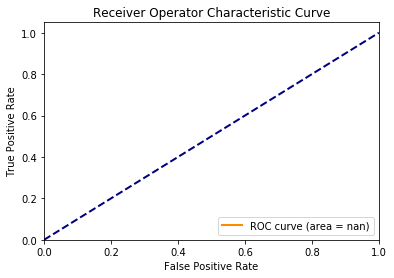

In [35]:
%matplotlib inline
plot_roc(y_test, get_max_probas(y_pred_probs))

This probably occured because I only included 1 fraudulent case in the training dataset...

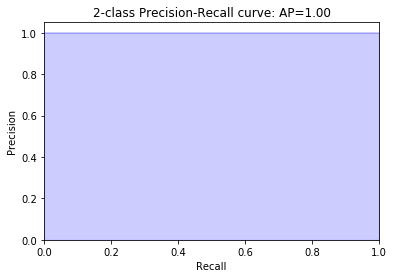

In [36]:
plot_prc(y_test, get_max_probas(y_pred_probs), y_pred)

Same as above.

## Alternate sampling strategy

Another sampling strategy to partition the number  of fraudulent cases I employ is split it as such:

* 60% fraudulent data for training
* 20% fraudulent data for validation
* 20% fraudulent data for testing (test set will comprise only of the fraudulent cases)

In [0]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = appropriate_df_sampler(principalDf)

In [0]:
predictions, anomaly_scores, model = fit_predict_score_outlier_detection_models("knn", X_train, X_val, y_train, y_val)

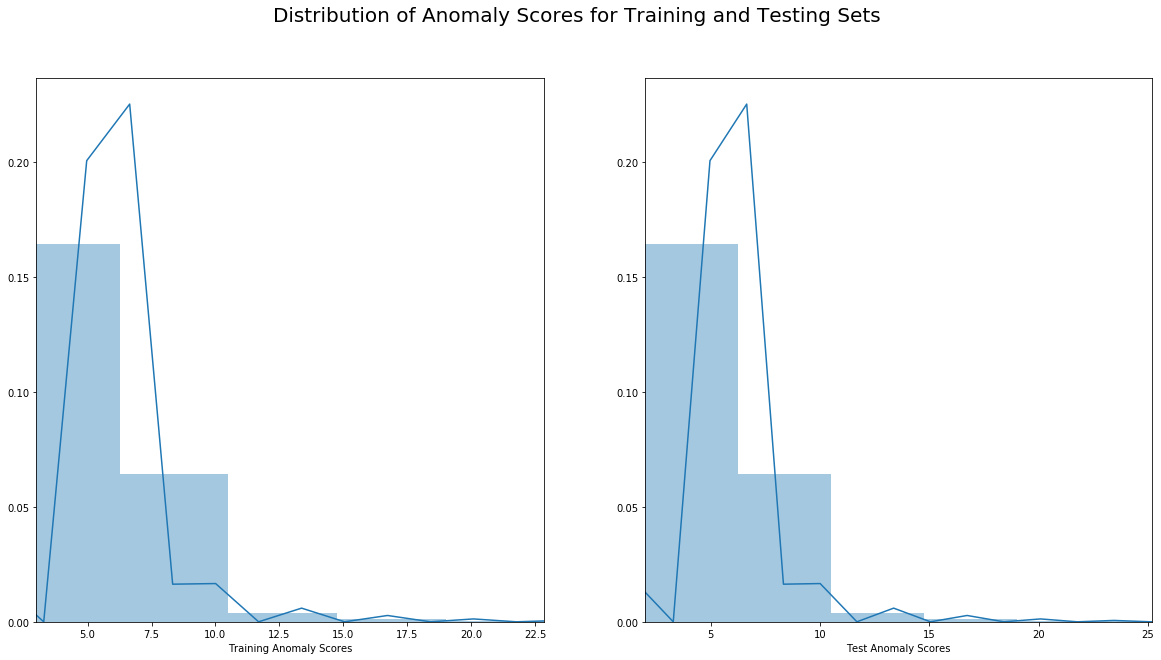

In [93]:
plot_anomaly_score_dists(anomaly_scores[0], anomaly_scores[1])

In [94]:
perform_mannwhitneyutest(anomaly_scores[0], anomaly_scores[1])

We reject the null hypothesis and conclude that the mean measurements between the two groups are statistically significantly different.


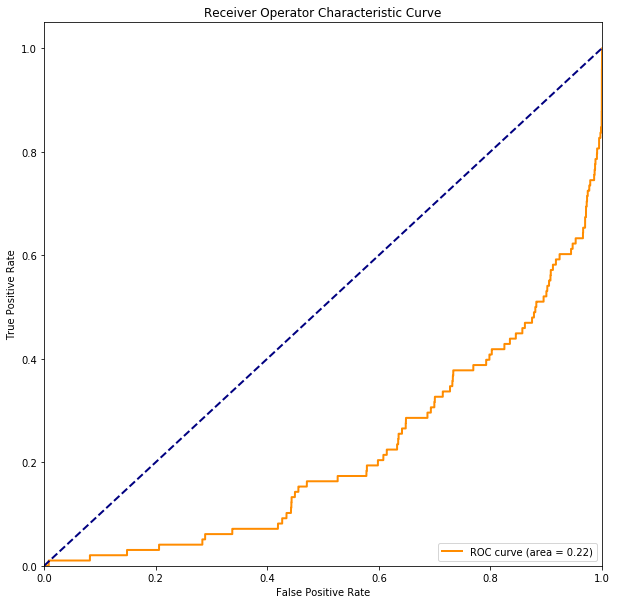

In [120]:
plot_roc(y_val, get_max_probas(predictions[1]))

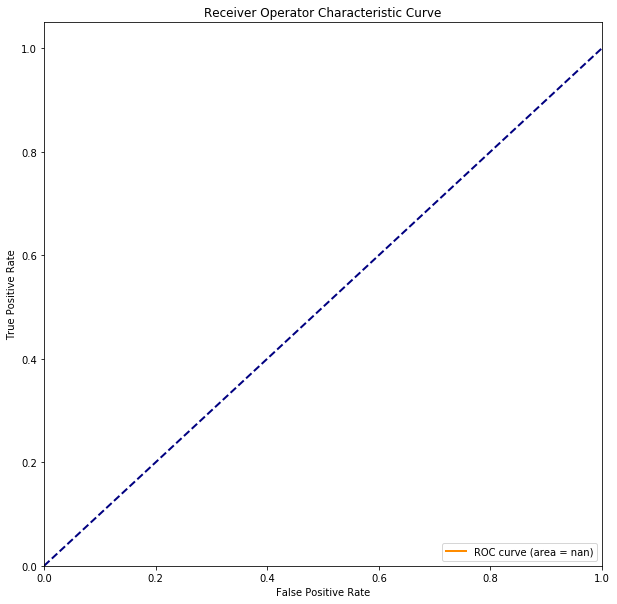

In [121]:
y_pred = model.predict(X_test)
plot_roc(y_test, get_max_probas(model.predict_proba(X_test)))

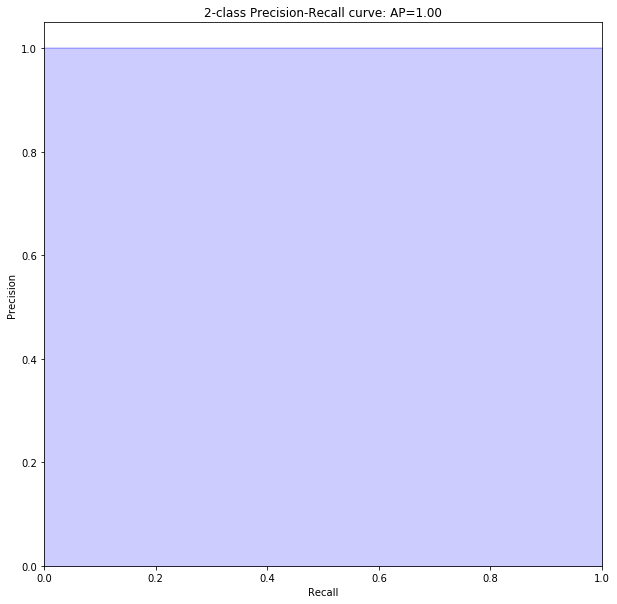

In [101]:
plot_prc(y_test, get_max_probas(model.predict_proba(X_test)), y_pred)

In [102]:
detailed_confusion_matrix(y_test, y_pred)

                           *Fraudulent Cases are considered Positive Cases
######################### Predicted Non-Fraudulent ### | ### Predicted Fraudulent ##########


Actually Non-Fraudulent | TN = 0                   | FP = 0


Actually Fraudulent     | FN = 50                       | TP = 48 


Specificity: 0.4897959183673469
Sensitivity (aka. Recall): nan


## Conclusion of Alternate Sampling Strat: DUD

In [0]:
# clustering/density based with DBSCAN/LOF, SVM, isolation forest, 

In [0]:
preds, anom_scores, model = fit_predict_score_outlier_detection_models("iforest", X_train, X_test, y_train, y_test)

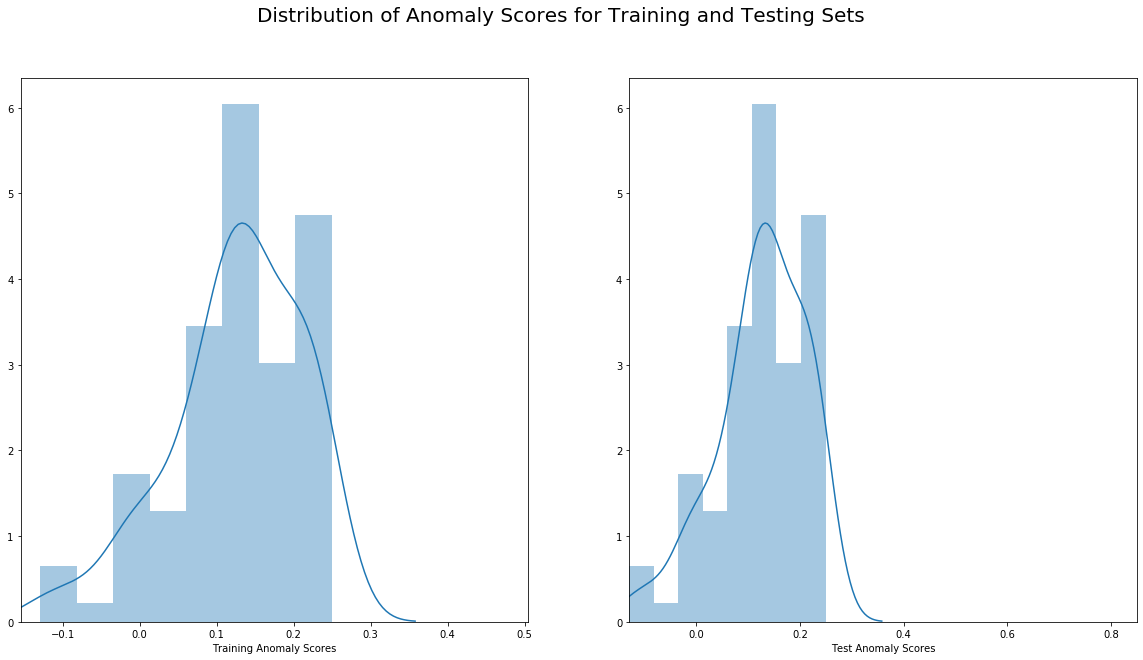

In [111]:
plot_anomaly_score_dists(anom_scores[0], anom_scores[1])

In [112]:
perform_mannwhitneyutest(anom_scores[0], anom_scores[1])

We reject the null hypothesis and conclude that the mean measurements between the two groups are statistically significantly different.


In [0]:
y_pred = model.predict(X_test)
plot_roc(y_test, get_max_probas(model.predict_proba(X_test)))

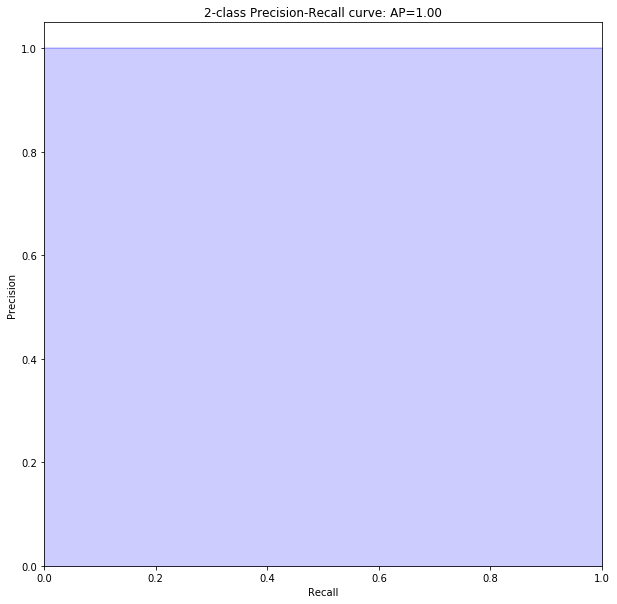

In [117]:
plot_prc(y_test, get_max_probas(model.predict_proba(X_test)), y_pred)

In [118]:
detailed_confusion_matrix(y_test, y_pred)

                           *Fraudulent Cases are considered Positive Cases
######################### Predicted Non-Fraudulent ### | ### Predicted Fraudulent ##########


Actually Non-Fraudulent | TN = 0                   | FP = 0


Actually Fraudulent     | FN = 50                       | TP = 48 


Specificity: 0.4897959183673469
Sensitivity (aka. Recall): nan


## Conclusion

Of IForest with 'appropriate' sampling a model that does a terrible job of classifying whether a sample is fraudulent or not... There must be some method to rectify this.

## Addressing Class Imbalance - Down Sampling Majority Class

Another approach to addressing the problem of class imbalance is with down-sampling the majority class. This is something we've done before in a few other problems, and it might not be an option in all the cases. In this case, however, I think we have enough data points in total, and enough cases of the majority class we can down sample from. 

Keep in mind, we want to downsample to include the most influential and representative samples to learn from from the majority negative class. We will be making use of the SMOTE python library and its methods to select an approprirate down-sampling strategy for our problem

In [0]:
# only non-fraudulent cases for this test
X_test, y_test = sample_for_test_set(principalDf, include_minority=False)

In [0]:
y_pred = fitted_model.predict(X_test)
y_pred_probs_max = get_max_probas(fitted_model.predict_proba(X_test))

In [0]:
y_pred = pd.Series(y_pred)
y_pred.value_counts()

In [0]:
detailed_confusion_matrix(y_test, y_pred)

In [0]:
plot_roc(y_test, y_pred_probs_max)

In [0]:
print(f"{1753/(1753+83541)} %")

There were no fraudulent cases in this step, however, there alarm in the model went off in the cases of 1753 cases, with this type of naive sampling in this instance. This model therefore would cause unncessary harm and arm in its clients 2% of the time, which is too shockingly high of a number. This needs to be lowered because the harm and alarm of false positive cases can be enough for your clients to end their relationship with you.

In [0]:
plot_roc(y_test, y_pred)

## Undersampling of the Majority Class with OneSidedSelection

In the contrary, OneSidedSelection will use TomekLinks to remove noisy samples [KM1997]. In addition, the 1 nearest neighbor rule is applied to all samples and the one which are misclassified will be added to the set C. No iteration on the set S will take place.

In [0]:
from imblearn.under_sampling import OneSidedSelection
oss = OneSidedSelection(random_state=0)
X_resampled, y_resampled = oss.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

In [0]:
OSS_df = pd.DataFrame(np.c_[X_resampled, y_resampled], columns=principalDf.columns)

In [0]:
param_grid = {
    "n_neighbors":[3, 4, 5]
}

knn_data_bundle, fitted_model, elapsed_time = fit_get_predictions_with_CV(OSS_df, "KNN", param_grid)

y_pred = knn_data_bundle[4]
y_test = knn_data_bundle[3]

In [0]:
report_df = report_performance_scores(fitted_model, y_test, y_pred, elapsed_time)
report_df.head()

In [0]:
plot_roc(y_test, y_pred)

This method seems like a more balanced approach to undersampling the minority case. We see that we've kept the same number of majority cases somehow, but achieved much better performance with this type of sampling strategy. I've not read in depth about how the sampling strategy employed but I think it will be important to know how it is done. Something about Tomek links.

## Test Modeling against Test dataset (previous majority down sampling)

Create a test data set by resampling a portion of the non-fraud cases and make that the entire test dataset.

In [0]:
# only non-fraudulent cases for this test
X_test, y_test = sample_for_test_set(principalDf, include_minority=False)

In [0]:
y_pred = fitted_model.predict(X_test)

In [0]:
y_pred = pd.Series(y_pred)
y_pred.value_counts()

In [0]:
plot_roc(y_test, y_pred)

In [0]:
# Include minority cases in the sampling
X_test, y_test = sample_for_test_set(principalDf, fraction=0.5, include_minority=True)

In [0]:
y_pred_probs = fitted_model.predict_proba(X_test)
y_pred = fitted_model.predict(X_test)

In [0]:
y_pred = pd.Series(y_pred)
y_pred.value_counts()

In [0]:
report = report_performance_scores(fitted_model, y_test, y_pred, elapsed_time)
report.head()

In [0]:
y_pred = fitted_model.predict(X_test)
y_pred_probs = fitted_model.predict_proba(X_test)
y_pred_probs_max = get_max_probas(y_pred_probs)

In [0]:
plot_roc(y_test, y_pred_probs_max)

In [0]:
detailed_confusion_matrix(y_test, y_pred)

# Conclusion of Down Sampling Strategy

Using the OneSideSelection down sampling strategy, fitting a model to this dataset, and then testing on a purely majority-class dataset yields positive expected values (i.e., almost 0 fraudulent cases predicted), meaning that the decision function has learned of some of the patterns for fraudulent activity.

Having a higher Sensitivity score here is important because we want to capture as much of the fraudulent activity as possible, while mitigating the number of missed-detections and the number of false-alarms. In this case, there were 30 missed fraudulent cases that went under the radar and 5 false alarms for the 124 pings for frauduldent activity.

This is a start but this is certainly not good enough. We need to get that False-Positive rate/Missed-Fraudulent number as low as possible.

### Over sampling of the Minority Class

We over sample the minority class to have more examples to learn from, but rather than just randomly doing it, there are some technicality to the approaches that we can choose. I'll go through training a decision function with resampling using two powerful methods offered by the imbalanced-learn library:

1) SMOTE - Synthetic Minority Oversampling Technique

2) ADASYN - Adaptive Synthetic sampling

These two oversampling approaches use methods of interpolation to generate synthetic samples as opposed to the type of sampling done with Random over sampling, which duplicates examples.

Formula for SMOTE sample generation:

![Formula for SMOTE sample generation](https://imbalanced-learn.readthedocs.io/en/stable/_images/math/7d17f8d1d74c655eb15821661276d94c82d0e5b4.png)

Lambda is a value between 0 and 1 and a sample is interpolated along the line between Xi and Xzi.

<br>

![Sampling](https://imbalanced-learn.readthedocs.io/en/stable/_images/sphx_glr_plot_illustration_generation_sample_0011.png)



In [0]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

In [0]:
smote_df = pd.DataFrame(np.c_[X_resampled, y_resampled], columns=principalDf.columns)

In [0]:
param_grid = {
    "n_neighbors":[3, 4, 5]
}

knn_data_bundle, fitted_model, elapsed_time = fit_get_predictions_with_CV(smote_df, "KNN", param_grid)

y_pred = knn_data_bundle[4]
y_test = knn_data_bundle[3]

In [0]:
report_df = report_performance_scores(fitted_model, y_test, y_pred, elapsed_time)
report_df.head()

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, train_size=0.3, random_state=42)
y_pred_probs = fitted_model.predict_proba(X_test)
y_pred_probs_max = get_max_probas(y_pred_probs)

In [0]:
plot_roc(y_test, y_pred_probs_max)